# Denoising Diffusion Probabilistic Models (DDPM) on MNIST

In [1]:
# Python imports
import random
import math
import abc
import os

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate

# Own imports
import utils

## 0. Constants

In [37]:
# Hyper-parameters.
LEARNING_RATE_START = 5e-4
EPOCHS = 10
BATCH_SIZE = 64
DROPOUT = 0.1

# Diffusion model parameters.
TIME_STEPS = 500

# UNet model parameters.
TIME_EMBEDDING_CHANNELS = 384
GROUP_NORM_GROUPS = 32

# Dataset parameters.
WIDTH = 28
HEIGHT = 28
CHANNELS = 1

# Others
SAVED_FILENAME = 'MNIST'

### 0.1. Device

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Print the device to run the model.
print(f"Use device [{DEVICE}].")

Use device [cuda].


## 1. Dataset

In [4]:
# 1. Each item in dataset is a tuple of (torch.Tensor, int). The first tensor is of shape (CHANNELS, HEIGHT, WIDTH) and dtype torch.float32, which is the image.
# 2. I use a custom utils.MNIST to load and cache the dataset, so that reading from hard drive during training is avoided.
dataset = utils.MNIST(
    './data',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Resize((HEIGHT, WIDTH), antialias=True),
        torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
    ]),
)

# samples = next(iter(dataloader))
# samples is a Python list of len 2.
# samples[0] is a tensor of shape (BATCH_SIZE, CHANNELS, WIDTH, HEIGHT)
# samples[1] is a tensor of shape (BATCH_SIZE,)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Inspect statistics of the dataset.

In [5]:
# Get the size of the dataset.
dataset_size = len(dataset)

# Construct data structures used by tabulate.
headers = ['Property', 'Value']
rows = [
    ['Size', dataset_size],
]

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Property   |   Value |
|------------|---------|
| Size       |   60000 |


Inspect samples from the dataset.

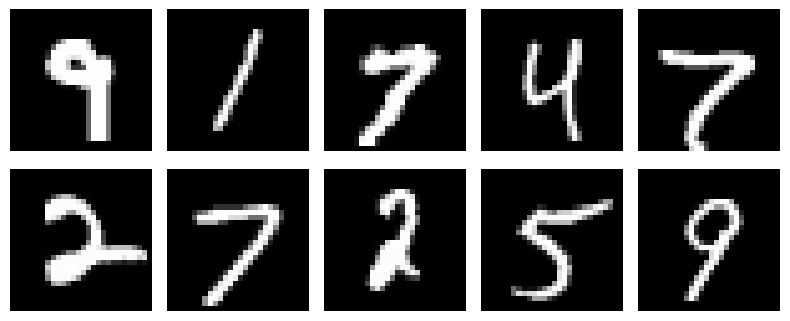

In [6]:
# Sample 10 unique indices from the index range of the dataset.
indices = random.sample(range(dataset_size), k=10)

# Plot figure.
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(8, 3.5))
for i in range(len(indices)):
    row = i // cols
    col = i % cols
    axs[row][col].imshow(dataset[indices[i]][0].permute(1, 2, 0), cmap=plt.cm.gray)
    axs[row][col].axis('off')
plt.tight_layout()
plt.show()

## 2. Diffusion

In [22]:
class Diffusion:
    """Difusion class performs forward and backward diffusion."""

    def __init__(self, time_steps=1000):
        """
        Args:
            timesteps (int): maximum diffusion timesteps.
        """

        # Remember the instance attributes.
        self.time_steps = time_steps

        # Perform pre-calculations.
        self._performPreCalculations()

    def q_sample(self, x_0, t):
        """Perform forward diffusion.
        
        Args:
            x_0 (shape (batch_size, channels, height, width) & dtype torch.float32): original images.
            t (shape (batch_size,) & dtype torch.int64): time representation.

        Returns: noisy images of shape (batch_size, channels, height, width) and dtype torch.float32.
        """

        # Noise added to the images.
        # A tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
        noise = torch.randn_like(x_0)

        # A tensor of shape (batch_size, 1, 1, 1) and dtype torch.float32.
        sqrt_alphas_cumprod = self._gatherFromTensor(self.sqrt_alphas_cumprod, t)
        # A tensor of shape (batch_size, 1, 1, 1) and dtype torch.float32.
        sqrt_one_minus_alphas_cumprod = self._gatherFromTensor(self.sqrt_one_minus_alphas_cumprod, t)

        # A tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise

    def _beta_schedule(self):
        """Generate betas for adding noise to images in a linear way.

        The article [1] uses 1000 time steps, and uses 0.0001 as the starting beta and 0.02 as the ending beta.
        If we use a different time steps, we need to scale it to make sure the noised added is enough.

        Return: A tensor of shape (self.time_steps,) and dtype torch.float32.
        """

        # Calculate the scale of the starting and ending betas.
        scale = 1000 / self.time_steps

        # Scale the starting and ending betas.
        beta_start_scaled = 0.0001 * scale
        beta_end_scaled = 0.02 * scale

        # Return a tensor of shape (self.time_steps,) and dtype torch.float32.
        return torch.linspace(start=beta_start_scaled, end=beta_end_scaled, steps=self.time_steps, device=DEVICE)

    def _performPreCalculations(self):
        """Perform pre-calculations."""

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        betas = self._beta_schedule()

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        alphas = 1 - betas

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        self.alphas_cumprod = alphas.cumprod(dim=0)

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod).sqrt()

    def _gatherFromTensor(self, tensor, t):
        """Gather from tensor by the index t and make the shape as (batch_size, 1, 1, 1).

        Args:
            tensor (shape (self.time_steps,) & dtype torch.float32): tensor to gather from.
            t (shape (batch_size,) & dtype torch.int64): time representation.

        Return: A tensor of shape (batch_size, 1, 1, 1).
        """

        # Calculate the batch size.
        batch_size = t.size()[0]

        # A tensor of shape (batch_size,) and torch.float32.
        tensor = tensor.gather(dim=0, index=t)

        # A tensor of shape (batch_size, 1, 1, 1) and torch.float32.
        return tensor.reshape(batch_size, 1, 1, 1)

diffusion = Diffusion(TIME_STEPS)

### 2.1. Forward Diffusion

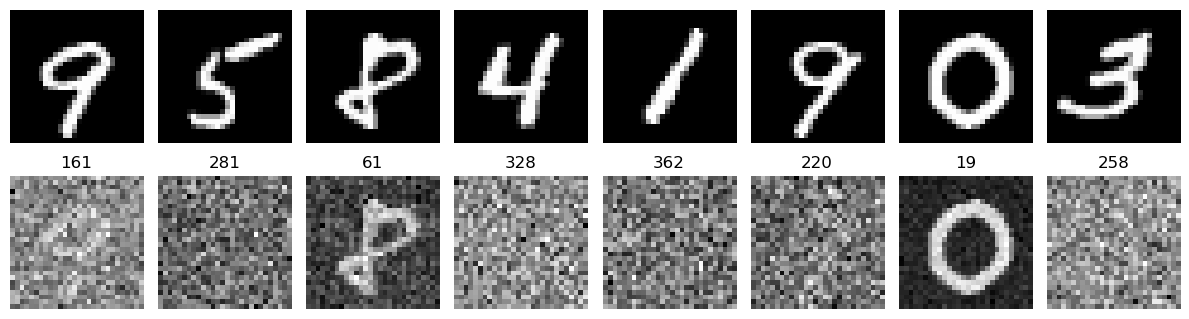

In [31]:
num_samples = 8

# Sample images from the dataset.
# A tensor of shape (num_samples, CHANNELS, HEIGHT, WIDTH) and dtype torch.float32.
images = next(iter(dataloader))[0][:num_samples].to(DEVICE)

# Sample time steps that are in [0, TIME_STEPS).
# A tensor of shape (num_samples,) and dtype torch.int64.
t = torch.randint(0, TIME_STEPS, (8,), device=DEVICE)

# Add noise to the images.
# A tensor of shape (num_samples, CHANNELS, HEIGHT, WIDTH) and dtype torch.float32.
noisy_images = diffusion.q_sample(images, t)

# Show the noisy images.
rows, cols = 2, num_samples
fig, axs = plt.subplots(rows, cols, figsize=(12, 3.5))
for col in range(cols):
    axs[0][col].imshow(images[col].permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    axs[0][col].axis('off')
for col in range(cols):
    axs[1][col].imshow(noisy_images[col].permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    axs[1][col].axis('off')
    axs[1][col].set_title(t[col].item())
plt.tight_layout()
plt.show()

## 3. Model

### 3.1. Time embedding.

In [33]:
def time_embedding(t, dims, period_max=10000.):
    """Calculate embedding for time steps.

    Args:
        t (shape (batch_size,) & dtype torch.int64): time representation.
        dims (int): dimensions of the embedding.
        period_max(float): max period of sinusoidal and cosinoidal functions.

    Return: time embedding of shape (batch_size, dim) and dtype torch.float32.
    """

    # batch_size is a Python int.
    batch_size = t.size()[0]

    # Calculate half of the embedding dimension.
    # half is a Python int.
    half = dims // 2

    # Calculate the parameter w that controls frequencies.
    # A tensor of shape (half,) and dtype torch.float32.
    w = torch.exp(
        -math.log(period_max) *
        torch.arange(start=0, end=half, dtype=torch.float32, device=DEVICE) / half
    )
    
    # args is the arguments of sinusoidal and cosinoidal functions.
    # args is a tensor of shape (batch_size, half) and dtype torch.float32.
    # t[:, None] is a tensor of shape (batch_size, 1) and dtype torch.int64.
    # w[None, :] is a tensor of shape (1, half) and dtype torch.float32.
    args = t[:, None].float() * w[None, :]
    
    # A tensor of shape (batch_size, half*2) and dtype torch.float32.
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    # A tensor of shape (batch_size, dim) and dtype torch.float32.
    if dims % 2 != 0:
        embedding = torch.cat([embedding, torch.zeros(batch_size, 1)], dim=-1)

    # A tensor of shape (batch_size, dim) and dtype torch.float32.
    return embedding

### 3.2. Blocks

Define a module that accepts time embedding.

In [34]:
class EmbeddingBlock(torch.nn.Module, abc.ABC):
    """Any module whose forward method takes time embedding as a second argument."""

    @abc.abstractmethod
    def forward(self, x, embedding):
        """Take x and embbeding as the inputs."""

Define a sequential module that contains EmbeddingBlock.

In [ ]:
class EmbeddingSequential(torch.nn.Sequential, EmbeddingBlock):
    """A sequential module that contains EmbeddingBlock."""

    def forward(self, x, embedding):
        """Take x and embbeding as the inputs."""

        for layer in self:
            if isinstance(layer, EmbeddingBlock):
                x = layer(x, embedding)
            else:
                x = layer(x)
        
        return x

Define the residual block.

In [40]:
class ResidualBlock(EmbeddingBlock):
    """Residual block."""

    def __init__(self, in_channels, out_channels, time_embedding_channels=TIME_EMBEDDING_CHANNELS, groups=GROUP_NORM_GROUPS, dropout=DROPOUT):
        """
        Args:
            in_channels (int): channels of the input.
            out_channels (int): channels of the output.
            time_embedding_channels (int): channels of the time embedding.
            groups (int): number of groups for group normalization. in_channels and out_channels must be divisible by groups.
            dropout (float): dropout rate.
        """

        super().__init__()

        # Input is a tensor of shape (batch_size, in_channels, height, width) and dtype torch.float32.
        # Output is a tensor of shape (batch_size, out_channels, height, width) and dtype torch.float32.
        self.conv1 = torch.nn.Sequential(
            torch.nn.GroupNorm(groups, in_channels),
            torch.nn.SiLU(),
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
        )

        # Input is a tensor of shape (batch_size, time_embedding_channels) and dtype torch.float32.
        # Output is a tensor of shape (batch_size, out_channels) and dtype torch.float32.
        self.embedding = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(time_embedding_channels, out_channels),
        )

        # Input is a tensor of shape (batch_size, out_channels, height, width) and dtype torch.float32.
        # Output is a tensor of shape (batch_size, out_channels) and dtype torch.float32.
        self.conv2 = torch.nn.Sequential(
            torch.nn.GroupNorm(groups, out_channels),
            torch.nn.SiLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
        )

        # Skip connection.
        if in_channels != out_channels:
            self.shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = torch.nn.Identity()

    def forward(self, x, embedding):
        """
        Args:
            x (shape (batch_size, in_channels, height, width) & dtype torch.float32)
            embedding (shape (batch_size, time_embedding_channels) & dtype torch.float32)

        Return: a tensor of shape (batch_size, out_channels, height, width) and dtype torch.float32.
        """

        # A tensor of shape (batch_size, out_channels, height, width) and dtype ttorch.float32.
        out = self.conv1(x)
        # A tensor of shape (batch_size, out_channels, height, width) and dtype ttorch.float32.
        out += self.embedding(embedding)[:, :, None, None]
        # A tensor of shape (batch_size, out_channels, height, width) and dtype ttorch.float32.
        out = self.conv2(out)

        # A tensor of shape (batch_size, out_channels, height, width) and dtype ttorch.float32.
        return out + self.shortcut(x)